In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set styling options
# plt.style.use('ggplot')
# sns.set_palette('deep')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Load the grid search results
with open('../data/models/grid_search/grid_search_results.json', 'r') as f:
    grid_data = json.load(f)

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(grid_data['results'])

# Display basic information
print(f"Total number of parameter combinations tested: {len(results_df)}")
results_df.head(3)

Total number of parameter combinations tested: 72


,run_id,params,test_rmse,test_mae,training_time,precision@10,precision@20,recall@10,recall@20,ndcg@10,ndcg@20
0,run_6,"{'n_factors': 5, 'learn_rate': 0.001, 'bias_le...",1.164411,0.874223,128.851964,0.813469,0.773021,0.732223,0.887998,0.770360,0.811389
1,run_8,"{'n_factors': 5, 'learn_rate': 0.001, 'bias_le...",1.164415,0.874227,129.306876,0.813469,0.773021,0.732223,0.887998,0.770361,0.811389
2,run_5,"{'n_factors': 5, 'learn_rate': 0.001, 'bias_le...",1.164408,0.874387,129.881045,0.813128,0.773078,0.731946,0.888022,0.769985,0.811241


In [3]:
def get_best_params_for_metric(df, metric_name, higher_is_better=True):
    """Get the best parameters for a given metric."""
    if higher_is_better:
        best_idx = df[metric_name].idxmax()
    else:
        best_idx = df[metric_name].idxmin()

    best_row = df.loc[best_idx]
    return best_row['params'], best_row[metric_name], best_row['run_id']

# Create a table of best parameters for each metric
metrics = [col for col in results_df.columns if col not in ['run_id', 'params', 'training_time']]
lower_is_better = ['test_rmse', 'test_mae']
higher_is_better = [m for m in metrics if m not in lower_is_better]

# Create DataFrames to hold results
best_params_data = []

for metric in lower_is_better:
    params, value, run_id = get_best_params_for_metric(results_df, metric, higher_is_better=False)
    best_params_data.append({
        'Metric': metric,
        'Best Value': value,
        'Best Parameters': str(params),
        'Run ID': run_id
    })

for metric in higher_is_better:
    params, value, run_id = get_best_params_for_metric(results_df, metric, higher_is_better=True)
    best_params_data.append({
        'Metric': metric,
        'Best Value': value,
        'Best Parameters': str(params),
        'Run ID': run_id
    })

best_params_df = pd.DataFrame(best_params_data)
best_params_df.sort_values('Metric').reset_index(drop=True)

,Metric,Best Value,Best Parameters,Run ID
0,ndcg@10,0.770427,"{'n_factors': 20, 'learn_rate': 0.001, 'bias_l...",run_52
1,ndcg@20,0.811389,"{'n_factors': 5, 'learn_rate': 0.001, 'bias_le...",run_8
2,precision@10,0.814492,"{'n_factors': 5, 'learn_rate': 0.001, 'bias_le...",run_3
3,precision@20,0.773589,"{'n_factors': 5, 'learn_rate': 0.002, 'bias_le...",run_11
4,recall@10,0.732932,"{'n_factors': 10, 'learn_rate': 0.002, 'bias_l...",run_38
5,recall@20,0.889463,"{'n_factors': 5, 'learn_rate': 0.002, 'bias_le...",run_11
6,test_mae,0.873862,"{'n_factors': 20, 'learn_rate': 0.001, 'bias_l...",run_50
7,test_rmse,1.164408,"{'n_factors': 5, 'learn_rate': 0.001, 'bias_le...",run_5


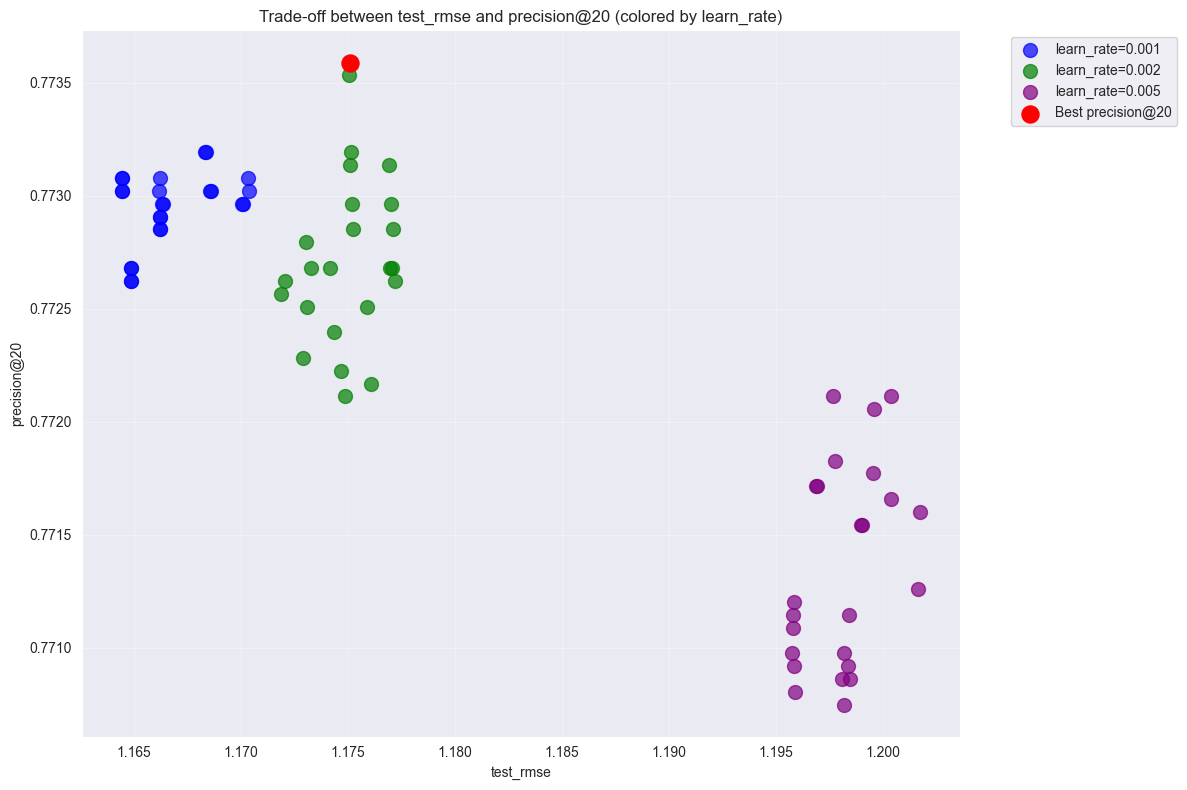

In [4]:
params_df = pd.json_normalize(results_df['params'])
analysis_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

def plot_metric_tradeoff(df, x_metric, y_metric, color_by='learn_rate'):
    """Plot trade-off between two metrics with points colored by a parameter."""
    plt.figure(figsize=(12, 8))

    # Simplified color setup - just use two fixed colors
    unique_values = sorted(df[color_by].unique())
    colors = ['blue', 'green', 'purple']

    for i, value in enumerate(unique_values):
        subset = df[df[color_by] == value]
        plt.scatter(subset[x_metric], subset[y_metric],
                   color=colors[i],
                   label=f'{color_by}={value}',
                   s=100, alpha=0.7)

    plt.xlabel(x_metric)
    plt.ylabel(y_metric)
    plt.title(f'Trade-off between {x_metric} and {y_metric} (colored by {color_by})')

    # Highlight best points
    best_x_idx = df[x_metric].idxmin() if x_metric in ['test_rmse', 'test_mae'] else df[x_metric].idxmax()
    best_y_idx = df[y_metric].idxmin() if y_metric in ['test_rmse', 'test_mae'] else df[y_metric].idxmax()

    plt.scatter(df.loc[best_y_idx, x_metric], df.loc[best_y_idx, y_metric],
               color='red', s=150, edgecolor='red', label=f'Best {y_metric}')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.show()

# Plot trade-off between RMSE and precision
plot_metric_tradeoff(analysis_df, 'test_rmse', 'precision@20')

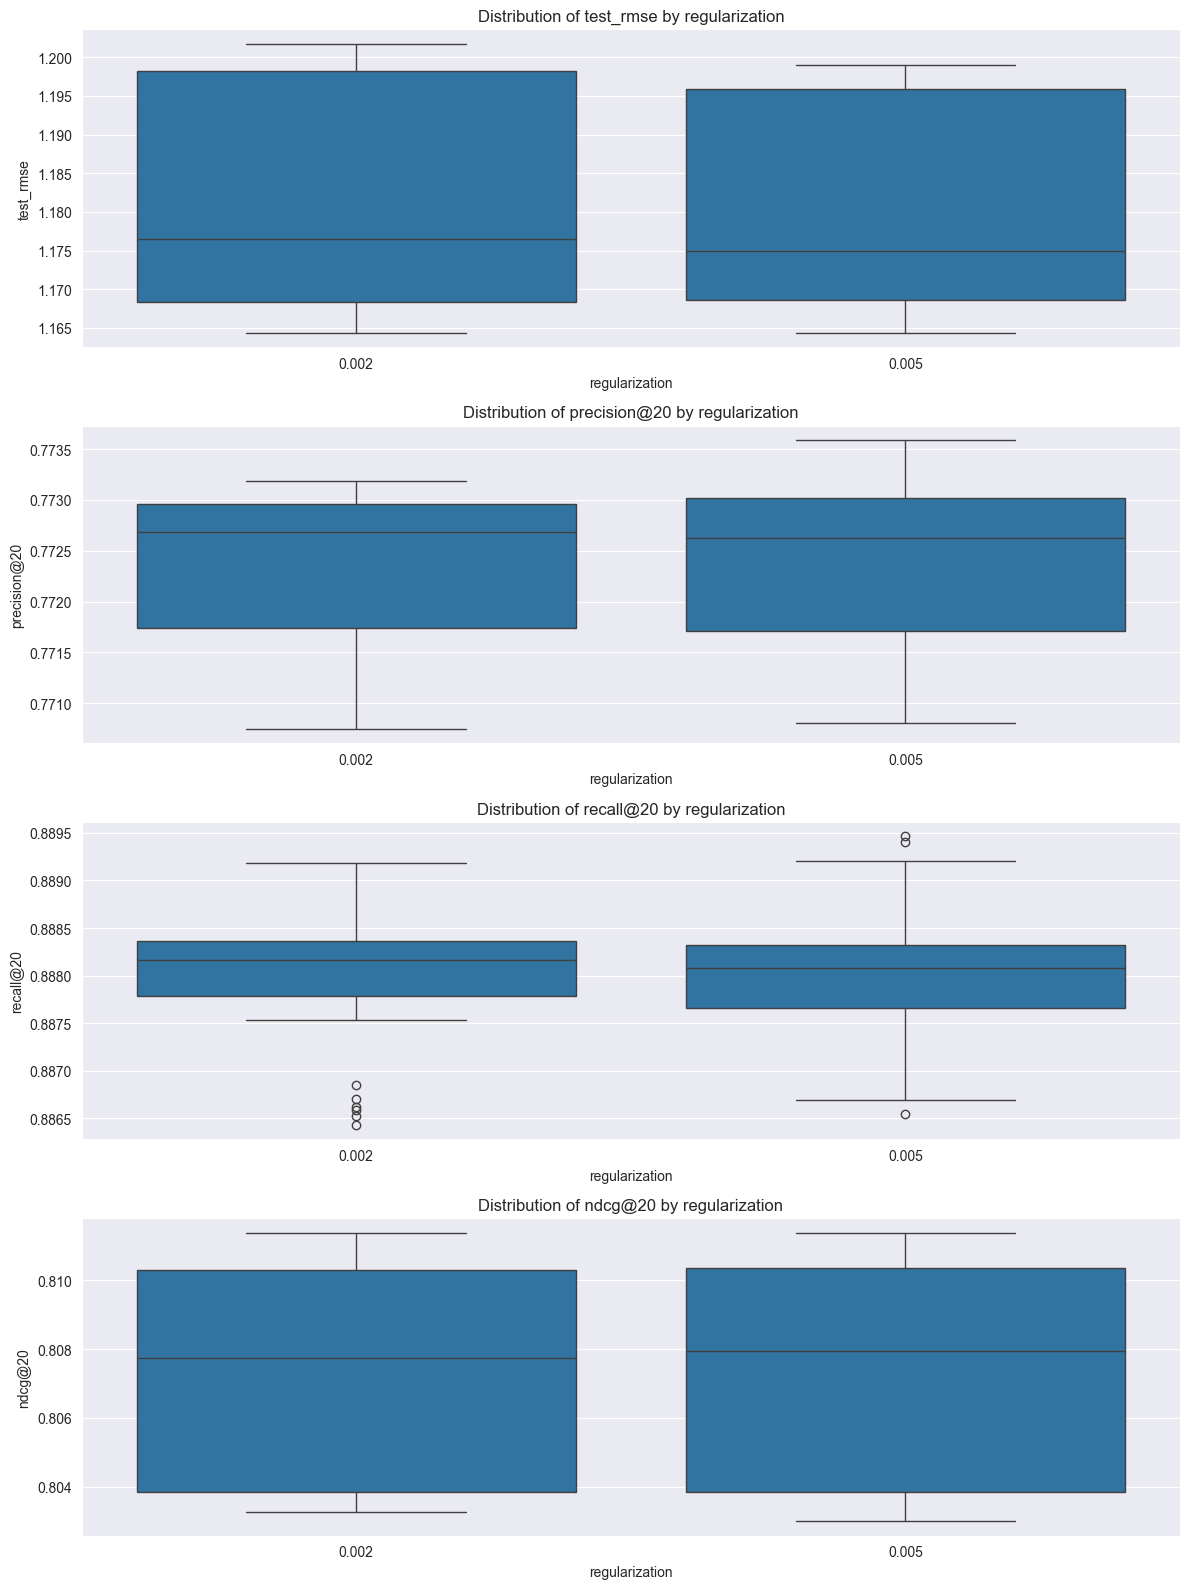

In [5]:
def plot_boxplots(df, param_name, metrics):
    """Create boxplots showing metric distribution by parameter value."""
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))

    for i, metric in enumerate(metrics):
        ax = axes[i] if len(metrics) > 1 else axes
        sns.boxplot(x=param_name, y=metric, data=df, ax=ax)
        ax.set_title(f'Distribution of {metric} by {param_name}')

    plt.tight_layout()
    plt.show()

# Create boxplots for n_factors
plot_boxplots(analysis_df, 'regularization', ['test_rmse', 'precision@20', 'recall@20', 'ndcg@20'])

In [6]:
# Get the overall best models (based on RMSE)
best_rmse_idx = analysis_df['test_rmse'].idxmin()
best_model = analysis_df.loc[best_rmse_idx]

# Create a summary table
summary_data = {
    'Parameter': ['n_factors', 'learn_rate', 'bias_learn_rate', 'regularization', 'bias_reg'],
    'Best Value': [
        best_model['n_factors'],
        best_model['learn_rate'],
        best_model['bias_learn_rate'],
        best_model['regularization'],
        best_model['bias_reg']
    ],
    'RMSE': best_model['test_rmse'],
    'Precision@10': best_model['precision@10'],
    'Recall@10': best_model['recall@10'],
    'NDCG@10': best_model['ndcg@10']
}

summary_df = pd.DataFrame({
    'Parameter': summary_data['Parameter'],
    'Optimal Value': summary_data['Best Value']
})

summary_metrics = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Precision@10', 'Recall@10', 'NDCG@10'],
    'Value': [
        best_model['test_rmse'],
        best_model['test_mae'],
        best_model['precision@10'],
        best_model['recall@10'],
        best_model['ndcg@10']
    ]
})

print("Optimal FunkSVD Parameters:")
display(summary_df)

print("\nPerformance with Optimal Parameters:")
display(summary_metrics)

Optimal FunkSVD Parameters:


,Parameter,Optimal Value
0,n_factors,5.000
1,learn_rate,0.001
2,bias_learn_rate,0.005
3,regularization,0.002
4,bias_reg,0.002



Performance with Optimal Parameters:


,Metric,Value
0,RMSE,1.164408
1,MAE,0.874387
2,Precision@10,0.813128
3,Recall@10,0.731946
4,NDCG@10,0.769985
